## Импорт библиотек

In [3]:
  # Библиотека с API для рекомендательных моделей
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 18.6 MB 335 kB/s 


In [4]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

# Сохранение и загрузка моделей
import pickle

# Графики
import matplotlib.pyplot as plt
import seaborn as sns

# Библиотека для рекомендаций Implicit
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking


/usr/local/lib/python3.7/dist-packages/implicit/gpu/__init__.py:14: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: no CUDA-capable device is detected (/project/./implicit/gpu/utils.h:71)'
  f"CUDA extension is built, but disabling GPU support because of '{e}'",


Немного модернизируем решение, предложенное в Baseline.

- В исходную функцию для подсчета метрик добавим **количество угаданных книг**

- В функцию перевода датафрейма в csr-матрицу добавим `словари`, чтобы не использовать внешние переменные

In [5]:
###############################################
# Исходные функции для модели с рекомендациями
##############################################

def contest_metric(df_solution, df_grd, print_report=True):

  """
  Возвращает метрики Recall, Precision, F1-score и количество угаданных книг  
  """

  pred = set(df_solution['chb'] + '_' + df_solution['sys_numb'].values)
  true = set(df_grd['chb'] + '_' + df_grd['sys_numb'].values) 
  recall = len(pred.intersection(true)) / len(true)
  precision = len(pred.intersection(true)) / (20 * len(df_grd['chb'].unique()))
  
  f1_score = 2 * (precision * recall) / (precision + recall)
  true_pairs_count = len(pred.intersection(true))

  if print_report == True:
    print(f"Угаданных книг: {true_pairs_count}")
    print(f"Recall: {round(recall, 5)}")
    print(f"Precision: {round(precision, 5)}")
    print(f"F1-score: {round(f1_score, 5)}")  

  return [true_pairs_count, recall, precision, f1_score]


def df_to_sparse(df, user_index_dict, item_index_dict):
  """
  Создает sparse-матрицу из датафрейма

  Данные о пользователях в столбце 'chb', данные о книгах - в столбце 'sys_numb`
  Внешние словари используются для получения ID каждого пользователя и книги
  """
  row = []
  col = []
  data = []

  for line in df.itertuples():
    row.append(user_index_dict[line.chb])
    col.append(item_index_dict[line.sys_numb])
    data.append(1)
  
  return csr_matrix((data, (row, col)))


##################################################################
# Подготовка данных для обучения
##################################################################

def recs_split_random(df, test_size):
  """
  Возвращает train и test, разделенные c помощью np.random
  """

  # Используем np.random для рандомизации индексов
  df['random'] = np.random.random(size=len(df))

  # Создаем маски индексов для train и test датасетов
  # test_size - размер валидационной выборки
  train_mask = df['random'] <  (1 - test_size)
  test_mask = df['random'] >= (1 - test_size)
  
  # Разделяем датасет на train и test, используя маски индексов
  train = df[train_mask]
  test = df[test_mask]
  return train, test


def split_and_prepare_recs_data(data, user_col, item_col, test_size,
                                weight_col='items', 
                                print_report=True,
                                delete_test_duplicates=True):
  
  """
  Разделяет на выборки, готовит данные для рекомендательных моделей 
  и выводит количество неизвестных user и item в тесте

  Возвращает train, test, полный датасет и веса
  Если в датасете только уникальные пары user-item, то все веса = 1
  """

  train_data, test_data = recs_split_random(data, test_size)
  all_data = data
  
  # Если создаем матрицу для implicit feedback (0, 1)
  if weight_col == 'items':
    # Отбираем столбцы с данными о пользователях и объектов рекомендации
    # Добавляем данные c частотой каждой пары user-item в поле 'items'
    train_data = (train_data.groupby([user_col, item_col])
                  .size()
                  .to_frame('items')
                  .reset_index())
    
    all_data = (data.groupby([user_col, item_col])
                  .size()
                  .to_frame('items')
                  .reset_index()) 
    
  # Удаляем дубликаты в тестовых данных
  if delete_test_duplicates == True:    
      test_data = (test_data.groupby([user_col, item_col])
                    .size()
                    .to_frame('items')
                    .reset_index())  

  # Нормализуем данные в поле weight_col
  # С параметром 'items' получим столбец из единиц
  train_weight = np.log2(train_data[weight_col] + 1)  
  all_weight = np.log2(all_data[weight_col] + 1)
 

  # Отдельные датасеты для пар user-item 
  train_data = train_data[[user_col, item_col]]
  test_data = test_data[[user_col, item_col]]
  all_data = all_data[[user_col, item_col]]

  # Cписки уникальных пользователей для train и test
  train_users = np.sort(train_data[user_col].unique())
  test_users = np.sort(test_data[user_col].unique())

  # Списки уникальных items для train и test
  train_items= np.sort(train_data[item_col].unique())
  test_items= np.sort(test_data[item_col].unique())

  # Новые users и items, незнакомые для модели
  # они не попадут в обучение
  cold_start_items = set(test_items) - set(train_items)
  cold_start_users = set(test_users) - set(train_users)

  if print_report:
    print("=> Количество пользователей")
    print(f"Общий датасет: {len(unique_transactions[user_col].unique())}")
    print(f"Обучающая выборка: {len(train_users)}")
    print(f"Валидационная выборка: {len(test_users)}")
    print()    
    print("=> Проблема cold start для модели")
    print("Неизвестных пользователей:", len(cold_start_users))
    print("Неизвестных объектов:", len(cold_start_items))
  
  # Набор датасетов для обучения рекомендательных моделей
  recs_datasets = {
      'train_user_item': train_data,
      'test_user_item': test_data,
      'all_user_item': all_data,
      'train_weight': train_weight,
      # 'test_weight': test_weight,
      'all_weight': all_weight
  }
  return recs_datasets

def get_user_item_matrix(user_items_df, user_col, item_col, 
                         user_item_weight_list):

  """Генерирует СSR-матрицу user-items в формате индексов для обучения моделей
  
  Возвращает:
  -------
  csr-матрица user-items с индексами
  словари для обратного перевода индексов user и item в исходные названия
  """
  
  # Cловари для маппинга индексов ID -> читатель/книга
  index_to_user = pd.Series(np.sort(np.unique(user_items_df[user_col])))
  index_to_item = pd.Series(np.sort(np.unique(user_items_df[item_col])))

  # Словари для обратного маппинга
  user_to_index = pd.Series(data=index_to_user.index, 
                            index=index_to_user.values)
  item_to_index = pd.Series(data=index_to_item.index, 
                            index=index_to_item.values)

  # Добавляем индексы в обучающий датасет
  user_items_df_indexed = user_items_df.copy()
  user_items_df_indexed['user_id'] = user_items_df[user_col].map(user_to_index)
  user_items_df_indexed['item_id'] = user_items_df[item_col].map(item_to_index)

  # Данные для перевода датасета в CSR матрицу
  data = user_item_weight_list
  rows = user_items_df_indexed['user_id']
  cols = user_items_df_indexed['item_id']

  # CSR матрица user(строки)-books(столбцы)
  user_items_csr = csr_matrix((data, (rows, cols)), 
                              shape=(len(user_to_index), len(item_to_index)))

  return user_items_csr, index_to_user, index_to_item


########################################################################
# Получение рекомендаций с помощью моделей implicit
########################################################################

def get_implicit_recommendations(trained_model_imp, user_items_matrix, 
                                 index_to_user_map, index_to_item_map, 
                                 top_n=20, filter_liked_items=True):  
  """
  Генерирует top_n рекомендаций с обученной моделью библиотеки implicit

  Возвращает:
  ----------
  Датафрейм, где каждая строка - список top_n рекомендаций для пользователя
  индексы - названия users, 
  данные - названия items из словарей index_to_user_map, index_to_item_map
  """

  # Получаем список рекомендаций - матрица с индексами книг и читателей
  recs_matrix = trained_model_imp.recommend_all(
      user_items=user_items_matrix, 
      N=top_n, 
      filter_already_liked_items=filter_liked_items
  )

  # Создаем датафрейм
  # Переводим индексы в исходные названия user и item
  recs_df = (
      pd.DataFrame(recs_matrix, index=index_to_user_map)
      .apply(lambda c: c.map(index_to_item_map))
  )

  return recs_df


def get_avg_recs_metrics(recs_matrix, valid_user_items_df,
                               user_col, item_col, 
                               print_report=True, round_n=4):
  """
  Считает и выводит усредненные метрики для матрицы рекомендаций

  Параметры:
  ---------
  recs_matrix - матрица предсказаний, строка = список рекомендаций для пользователя
  valid_user_items_df - валидационный датасет 
  """
  # Создаем словарь из валидационного датасета
  # ключ = user_name, значения = item_name
  user_items_dict = (
      valid_user_items_df
      .groupby(user_col)[item_col]
      .apply(set).to_dict()
  )
  
  # Ищем пересечение множества пользователей, на которых была обучена модель
  # с пользователями в валидационном датасете
  train_users = recs_matrix.index.to_list()
  valid_users = valid_user_items_df[user_col].unique()
  users_to_compare = set(train_users) & set(valid_users)

  # Считаем усредненные метрики по всем пользователям
  # hit-rate, precision, recall и f1-score
  hitrate = round(
      np.mean([int(len(set(recs_matrix.loc[u]) & user_items_dict[u]) > 0) for u in users_to_compare]), round_n)

  precision = round(
      np.mean([
      len(set(recs_matrix.loc[u]) & user_items_dict[u]) / 
      len(recs_matrix.loc[u]) for u in users_to_compare]), 5)

  recall = round(
      np.mean([
      len(set(recs_matrix.loc[u]) & user_items_dict[u]) / 
      len(user_items_dict[u]) for u in users_to_compare]), 5)

  f1_score = round(
      2 * (precision * recall) / (precision + recall), 5)


  if print_report:
    print(f"Hit-Rate_avg: {hitrate}")
    print(f"Recall_avg: {precision}")
    print(f"Precision_avg: {recall}")
    print(f"F1-score_avg: {f1_score}")
    
  return [hitrate, precision, recall, f1_score]


def matrix_recs_to_pairs(recs_matrix_df, 
                         user_col_name, item_col_name):
  """
  Переводит матрицу рекомендаций в датафрейм с парами user-item
  
  
  Параметры:
  --------
  recs_matrix_df - каждая строка [u]- список рекомендованных 
                   items для пользователя [u]  
  user_col_name - название столбца для user
  item_col_name - название столбца для item

  Возвращает датафрейм с двумя столбцами.
  """
  # Переводим 2D набор items в 1D список
  pairs_df= pd.DataFrame(recs_matrix_df.values.ravel(), 
                         columns=[item_col_name])
  
  # Количество столбцов = количество рекомендаций
  top_n = recs_matrix_df.shape[1]

  # Добавляем индексы пользователей по порядку
  # одинаковый индекс для каждых top_n строк
  pairs_df[user_col_name] = pairs_df.index  // top_n

  
  # Маппинг индексов в имена пользователей
  # используем матрицу рекомендаций 
  pairs_df[user_col_name] = pairs_df[user_col_name].map(
      (recs_matrix_df.reset_index()
       .rename(columns={'index':user_col_name})[user_col_name].to_dict())
  )

  return pairs_df



## Загрузка файлов

In [6]:
# Доступ к файлам на colab
import glob
import os

# Библиотека для работы с google drive
from google.colab import drive

# Монтируем диск
drive.mount('/content/drive')

# Смотрим файлы в директории
# !ls "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive


In [7]:
# Меняем домашнюю директорию
# для доступа к датасетам
os.chdir("/content/drive/My Drive/Colab Notebooks")

In [8]:
# Cчитывание данных

# читатели
users = pd.read_csv(
    './users.csv', sep=';', index_col=None, 
     dtype={'age': str, 'chb': str, 'chit_type': str, 'gender': str})

# книги
items = pd.read_csv(
    'items.csv', sep=';', index_col=None, 
     dtype={'author': str, 'bbk': str, 'izd': str, 
           'sys_numb': str, 'title': str, 'year_izd': str})

# история книг в библиотеке
transactions = pd.read_csv(
    'train_transactions_extended.csv', 
    sep=';', index_col=None,
    dtype={'chb': str, 'date_1': str, 'is_printed': str, 
            'is_real': str, 'source': str, 'sys_numb': str, 'type': str})

## ЭТАП 3. Возможности Collaborative Filtering

### (3.1) CF для активного пула читателей и книг

#### Вводные




`Collaborative Filtering` рассчитан на "активную" аудиторию:
  - рекомендации генерируются с помощью  информации о других пользователях и книгах.

У нас **новая система**, и она только начала пополняться данными об активности читателей и их предпочтениях:

  - Именно поэтому мы не можем получить `высокое качество` предсказаний

  - Если взять читателей и книги только из **"активного" пула**, покажет ли CF более высокие результаты?

Тогда для остальных пользователей мы сможем подобрать другой подход к рекомендациям и в итоге предложить **гибридное** решение:)

In [35]:
# Удаляем дубликаты
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()

#### Самые активные пользователи





In [36]:
# Создаем новый датафрейм с активностью пользователей
user_books_count = (
     unique_transactions.groupby('chb')
    .count().rename(columns={'sys_numb':'books_count'}))

print("Количество уникальных книг, взятых каждым пользователем:")
user_books_count.head(7)

Количество уникальных книг, взятых каждым пользователем:


,books_count
chb,
100000641403,3
100000644359,11
100000665127,17
100000676191,3
100000679200,6
100000681262,34
100000683677,2


- Вспомним, какая активность у большинства наших *читателей*

In [37]:
user_books_count.describe()

,books_count
count,16753.000000
mean,13.669313
std,70.121205
min,2.000000
25%,3.000000
50%,6.000000
75%,12.000000
max,6671.000000


1. 50% пользователей прочитали меньше 6 книг (среди них могут быть и новички, и те, кто в целом редко читает книги)

  - за нижнюю границу возьмем 6 книг

2. 25% пользователей взяли больше 12 книг, но среди них есть и рекордсмены с тысячами

  - попробуем найти границу для рекордсменов, которые скачивают все подряд)

In [38]:
print("99% пользователей прочитали < ",
      f"{int(user_books_count.books_count.quantile(0.99))} книг")

print("90% пользователей прочитали < ",
      f"{int(user_books_count.books_count.quantile(0.90))} книг")

99% пользователей прочитали <  111 книг
90% пользователей прочитали <  25 книг


- Попробуем взять верхнюю границу в `111 книг`

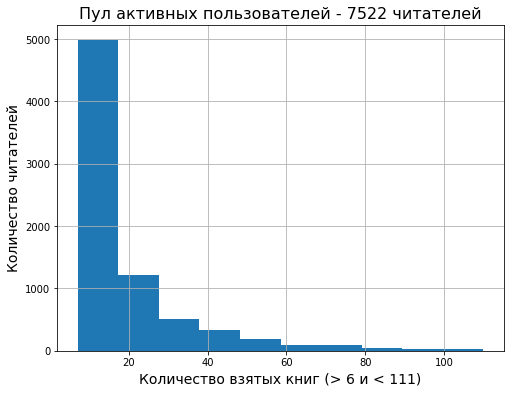

In [39]:
filter_111 = 'books_count > 6 and books_count < 111'

plt.figure(figsize=(8, 6))
user_books_count.query(filter_111).hist(ax=plt.gca())
plt.title(
    label="Пул активных пользователей - " + f"{user_books_count.query(filter_111).shape[0]} читателей", 
    size=16)
plt.xlabel("Количество взятых книг (> 6 и < 111)", fontsize=14)
plt.ylabel("Количество читателей", fontsize=14)
plt.show()

**Вывод**

1. Мы отобрали пользователей, которые прочитали от 6 до 111 книг (~половина)

  - попробуем обучить модель с рекомендациями на этом пуле

2. Мало книг не значит, что читатель неактивный, возможно, он только недавно пришел в библиотеку

  - пока нам это неважно, важно количество книг для качественных предсказаний

  - во время сегментации пользователей учтем этот нюанс!)

#### Книги, которые читают

In [40]:
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()

# Создаем новый датафрейм с количеством  читателей
# для каждой книги
books_popularity = (
    unique_transactions
    .groupby('sys_numb')
    .chb.count().to_frame()
    .rename(columns={'chb':'users_count'}))

books_popularity.describe()

,users_count
count,194666.000000
mean,1.176384
std,0.578743
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,21.000000


- Большинство книг читали только один раз, мы уже делали этот вывод в исследовании

- Посмотрим, сколько у нас останется книг в датасете, если их отфильтровать

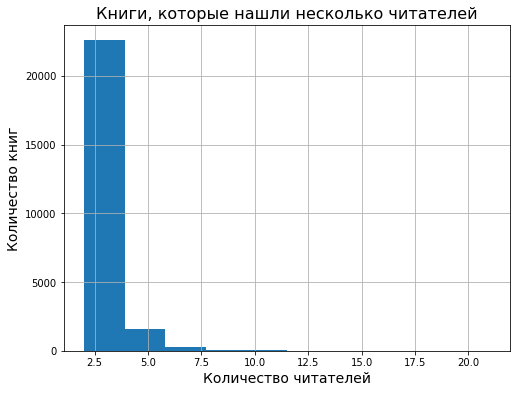

In [41]:
plt.figure(figsize=(8, 6))
books_popularity.query('users_count > 1').hist(ax=plt.gca())
plt.title(
    label="Книги, которые нашли несколько читателей", 
    size=16)
plt.xlabel("Количество читателей", fontsize=14)
plt.ylabel("Количество книг", fontsize=14)
plt.show();

**Вывод**

1. Пул "активных" книг ~12% от общего датасета с транзациями:

 - ~25 000 книг из 194 000 имеют больше 1-го читателя

2. По идее, это минимальный набор книг, которые имеет смысл включать в обучение с подходом Collaborative Filtering.

#### Эксперименты с моделью

##### Код для экспериментов

In [46]:
############################################################################
# Функции для экспериментов
############################################################################

def implicit_model_experiment(model_imp, dataset):
  
  """Обучает рекомендательную модель и возвращает результаты на тесте"""

  # Словарь с предобработанными датасетами для обучения
  recs_datasets = split_and_prepare_recs_data(dataset,
                                              'chb', 'sys_numb', 
                                              test_size=0.2, 
                                              print_report=False)

  # Формируем матрицы и словари с маппингом
  user_books_csr, users_dict, books_dict= get_user_item_matrix(
      recs_datasets['train_user_item'], 
      'chb', 'sys_numb', 
      recs_datasets['train_weight'])                                                       

  # Обучаем модель   
  model_imp.fit((user_books_csr * 40).astype('double'), show_progress=True)

  # Получаем список top-20 рекомендаций для каждого читателя
  recs_top_20 = get_implicit_recommendations(model_imp, 
                                          user_books_csr,
                                          users_dict, books_dict,
                                          filter_liked_items=True)                                 
  
  # Считаем усредненные показатели модели
  results = get_avg_recs_metrics(
      recs_top_20, 
      recs_datasets['test_user_item'],
      'chb', 'sys_numb', 
      print_report=False)
  
  return results


##### Фильтрация книг - как меняется датасет?

Посмотрим, как будет меняться набор пользователей и книг в датасете с разной степенью отсева "непопулярных" книг

In [47]:
book_filters_df = pd.DataFrame(index=['кол-во книг', 'кол-во users', 'books_count >'])

for min_users in [0, 1, 2, 3, 4, 5]:

  # Задаем фильтр для книг
  # по min количеству пользователей, которые их читали
  filter_books = 'users_count > @min_users'
   
  # Фильтруем датасет
  dataset = (unique_transactions
             .loc[lambda x: x.sys_numb.isin(
                 books_popularity.query(filter_books).index)]
             ) 
 
  book_filters_df[f"users > {min_users}"] = [
      # количество уникальных пользователей и книг
      dataset.sys_numb.nunique(),
      dataset.chb.nunique(),

      # минимальное количество книг в истории пользователей
      user_books_count[user_books_count.index.isin(dataset.chb)].books_count.min()
  ]

book_filters_df

,users > 0,users > 1,users > 2,users > 3,users > 4,users > 5
кол-во книг,194666,24597,5813,1997,861,429
кол-во users,16753,12547,7682,4703,2907,1829
books_count >,2,2,2,2,2,2


**Вывод**:

1. Самый большой `отсев книг ~ в 7 раз`:
  - если оставим книги, у которых есть хотя бы несколько читателей (users > 1)
2. В датасете останется `50% пользователей`:
  - если оставим книги, у которых уже больше 2-х читателей (users > 2)

Посмотрим, как такие выборки отразятся на качестве модели!

##### Модель для "активных" книг

In [48]:
# Датафрейм для результатов эксперимента
results_df = pd.DataFrame(index=['Hit-Rate_avg', 'Recall_avg', 'Precision_avg', 'F1-score_avg'])

# Создаем модель BRP
model_bpr = BayesianPersonalizedRanking(
    factors=200, learning_rate=0.3,  
    iterations=500,
    regularization=0.01)

In [49]:
# Обучаем модель на пулах книг с разной "активностью"
for min_users in [0, 1, 2, 3, 4]:

  # Задаем фильтр для книг
  # по min количеству пользователей, которые их читали
  filter_books = 'users_count > @min_users'
   
  # Фильтруем датасет
  filtered_dataset = (unique_transactions
                      .loc[lambda x: x.sys_numb.isin(
                          books_popularity.query(filter_books).index)]).copy()
  
  # Обучаем модель
  new_result = implicit_model_experiment(model_bpr, filtered_dataset)
  
  # Сохраняем результат в общей таблице
  results_df[f'books_cnt > {min_users}'] = new_result

# Выводим результаты эксперимента
results_df

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

,books_cnt > 0,books_cnt > 1,books_cnt > 2,books_cnt > 3,books_cnt > 4
Hit-Rate_avg,0.02250,0.09950,0.14420,0.18790,0.23000
Recall_avg,0.00127,0.00625,0.00864,0.01186,0.01540
Precision_avg,0.00817,0.05826,0.10203,0.14555,0.18228
F1-score_avg,0.00220,0.01129,0.01593,0.02193,0.02840


In [51]:
book_filters_df

,users > 0,users > 1,users > 2,users > 3,users > 4,users > 5
кол-во книг,194666,24597,5813,1997,861,429
кол-во users,16753,12547,7682,4703,2907,1829
books_count >,2,2,2,2,2,2


**Вывод**

1. Наша 1-я гипотеза подтвердилась! 

  - Если фокусироваться на активном пуле книг, то метод Сolloborative Filtering дает более высокие результаты

2. Метод `BPR` дает хорошее качество на менее "разреженных" матрицах и очень быстро обучается.

3. Можно попробовать отсеять книги с `users_count > 2` => уже получим 25% Hit Rate.


##### Модель для "активных пользователей"

In [52]:
# Обучаем модель на группах пользователей с разной "активностью"
for min_books in [1]:

  # Задаем фильтр для книг
  # по min количеству пользователей, которые их читали
  filter_users = 'books_count > @min_books and books_count < 111'
   
  # Фильтруем датасет
  filtered_dataset = (unique_transactions
                      .loc[lambda x: x.chb.isin(
                          user_books_count.query(filter_users).index)]).copy()
  
  # Обучаем модель
  new_result = implicit_model_experiment(model_bpr, filtered_dataset)
  
  # Сохраняем результат в общей таблице
  results_df[f'books_cnt > {min_books}'] = new_result

# Выводим результаты эксперимента
results_df

  0%|          | 0/500 [00:00<?, ?it/s]

,books_cnt > 0,books_cnt > 1,books_cnt > 2,books_cnt > 3,books_cnt > 4
Hit-Rate_avg,0.02250,0.02100,0.14420,0.18790,0.23000
Recall_avg,0.00127,0.00114,0.00864,0.01186,0.01540
Precision_avg,0.00817,0.00827,0.10203,0.14555,0.18228
F1-score_avg,0.00220,0.00200,0.01593,0.02193,0.02840


### (3.2) Дублирующиеся книги - баг или фича?

#### Вклад каждой книги в историю читателя

В процессе подготовки данных мы фиксировали частоту появления (веса) каждой книги для каждого пользователя: 

  - Такой подход был предложен разработчиками RankFM при тестировании их моделей в сравнении с ALS в Implicit.

  - Это актуально, например, если бы мы исследовали покупку товаров)

Так как мы преварительно удаляли все дубликаты user-book, то веса были равны 1.

Интересно, а как выглядела бы картина, если бы мы оставили исходные данные?

In [53]:
print("Книги, которые перечитывали много раз:")
books_read_twice = (transactions
                    .groupby(['chb', 'sys_numb'])
                    .size()
                    .to_frame('read_times')
                    .reset_index())

(books_read_twice
 .set_index('sys_numb')
 .join(items.set_index('sys_numb')['title'])
 .sort_values(by='read_times', ascending=False))

Книги, которые перечитывали много раз:


,chb,read_times,title
sys_numb,,,
RSL07000449201,300001090427,44,отсутствует
RSL01004357029,200000987642,42,"Переписка В. А. Жуковского и А. П. Елагиной, 1..."
RSL01010175347,300000850004,35,Система органов государственной власти в Респу...
RSL01006724299,200000957291,35,"Коллекционеры России, XVII - начало XX вв. : э..."
RSL01002745675,300000850004,26,Правопорядок в условиях формирования правового...
...,...,...,...
RSL01004063667,100001136730,1,"Пациенты диспансеров, страдающие шизофренией с..."
RSL01004063954,100001123223,1,Провоспалительные и противовоспалительные цито...
RSL01004063987,100001136730,1,Фармакогностическое изучение сухоцвета однолет...


- Какой контраст! Никто не перечитывал оптимизацию санитарно санитарно-эпидемиологического надзора и историю шизовфреников. Это радует:)

**Вывод**

1. У нас есть пул читателей, которые заказывали одну и ту же книгу по несколько раз:

  - возможно, заканчивался срок возврата книги
  - это любимые книги читателя
  - или какой-то сбой при загрузке книг


2. В прошлой имплементации удаление дубликатов снижало качество рекомендаций

  - Можно попробовать провести обучение еще раз, но в этот раз с нормализацией


#### Нормализация весов и обучение модели

Мы уже включили нормализацию в набор готовых функций, посмотрим как она работает:

In [54]:
print("Показатели после нормализации с np.log2:")

display(np.log2(books_read_twice['read_times'] + 1).sort_values(ascending=False))

Показатели после нормализации с np.log2:


213726    5.491853
86257     5.426265
80884     5.169925
144763    5.169925
144698    4.754888
            ...   
79217     1.000000
79218     1.000000
79219     1.000000
79220     1.000000
229001    1.000000
Name: read_times, Length: 229002, dtype: float64

- Мы значительно уменьшили вес "часто" читаемых книг с 40 до 5 

- Теперь они не будут перевешивать значимость других книжек, которые еще никто ниразу не взял повторно

Построим модель! Может быть теперь мы получим более высокое качество?

In [55]:
# Словарь с предобработанными датасетами для обучения
# Дубликаты не удаляем
recs_dict = split_and_prepare_recs_data(transactions, 
                                        'chb', 'sys_numb', 0.2)

=> Количество пользователей
Общий датасет: 16753
Обучающая выборка: 16666
Валидационная выборка: 12373

=> Проблема cold start для модели
Неизвестных пользователей: 87
Неизвестных объектов: 32125


In [56]:
# Формируем матрицы и словари с маппингом
user_books_csr, users_dict, books_dict= get_user_item_matrix(recs_dict['train_user_item'], 
                                                             'chb', 'sys_numb', 
                                                             recs_dict['train_weight'])                                                       

print("Размер sparse-матрицы user-books:", user_books_csr.shape)

Размер sparse-матрицы user-books: (16666, 162541)


In [57]:
alpha_value = 40

# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_books_csr * alpha_value).astype('double'))

/usr/local/lib/python3.7/dist-packages/implicit/utils.py:29: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  "OpenBLAS detected. Its highly recommend to set the environment variable "


  0%|          | 0/15 [00:00<?, ?it/s]

#### Оценка результатов

In [58]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=True)                                 

# Выводим усредненные показатели модели
get_avg_recs_metrics(recs_als_imp, recs_dict['test_user_item'],
                           'chb', 'sys_numb')

Hit-Rate_avg: 0.0285
Recall_avg: 0.0016
Precision_avg: 0.01051
F1-score_avg: 0.00278


[0.0285, 0.0016, 0.01051, 0.00278]

А если мы оставим все книги, которые попали в TOP-20 (параметр `filter_liked_items=False`)?


In [59]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=False)                                 

# Выводим усредненные показатели модели
get_avg_recs_metrics(recs_als_imp, recs_dict['test_user_item'],
                           'chb', 'sys_numb')

Hit-Rate_avg: 0.256
Recall_avg: 0.02139
Precision_avg: 0.1115
F1-score_avg: 0.03589


[0.256, 0.02139, 0.1115, 0.03589]

**Вывод**

- Ох как взлетело качество! Hit-Rate = 25% против 2%!

- Все потому, что многие пользователи нашей библиотеки часто обращаются к одним и тем же книгам.

"+" для хороших предсказаний, "-" для хороших рекомендаций =)

#### Тест на платформе



Сейчас мы узнаем актуальны ли дубликаты для тестовой платформы.

Данные у нас уже подготовлены, осталось обучить модель на полной выборке.

In [60]:
# Формируем матрицы и словари с маппингом
user_books_csr, users_dict, books_dict= get_user_item_matrix(recs_dict['all_user_item'], 
                                                             'chb', 'sys_numb', 
                                                             recs_dict['all_weight'])                                                       

print("Размер sparse-матрицы user-books:", user_books_csr.shape)

Размер sparse-матрицы user-books: (16753, 194666)


- В полной выборке у нас добавилось ~40 000 позиций книг

In [61]:
alpha_value = 40

# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_books_csr * alpha_value).astype('double'))

  0%|          | 0/15 [00:00<?, ?it/s]

- Не забываем отключить фильтр `filter_liked_items`

In [65]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=False)      
    
# Переводим матрицу рекомендаций в формат пар user-book
solution = matrix_recs_to_pairs(recs_als_imp, 'chb', 'sys_numb') 

# Сохраняем для теста на платформе
solution.to_csv("predictions_als_imp_duplicates.csv", index=False, sep=';')                   

print(f"Сохранено {len(solution)} предсказаний")

Сохранено 335060 предсказаний


**Вывод**

1. Платформа выдала нам результат в 0.0028 

  - делаем вывод, что дубликатов в тесте не так много)

2. Когда мы выясним, откуда у пользователей по 1000 повторных прочтений книг
  - можно  использовать как  фичу "книги, которые перечитывают":
  - а пока для нас это только баг:)

### (3.3) Рекомендации новых авторов

#### Вводные

Попробуем построить такую же систему рекомендаций на базе Collaborative Filtering, но для авторов:)

- Сможем ли мы открыть для читателей новых авторов?

- Могут ли авторы помочь в предсказании новых книг?

#### Добавляем авторов в датасет



In [67]:
unique_transactions = transactions[['chb', 'sys_numb']].drop_duplicates()
print("размер датасета до объединения:", unique_transactions.shape[0])

# Создаем временные индексы для объединения items и transactions
# Добавляем в transactions авторов книг
unique_transactions = (unique_transactions
                       .set_index('sys_numb')
                       .join(items.set_index('sys_numb')['author'])
                       .reset_index()
                      )

print("после добавления авторов:", unique_transactions.shape[0])

unique_transactions.head(5)               

размер датасета до объединения: 229002
после добавления авторов: 229002


,sys_numb,chb,author
0,RSL01000000123,100000934918,"Боронов, Адина Айылчиевич"
1,RSL01000000244,300001043470,"Дедов, Александр Викторович"
2,RSL01000000259,300001090044,"Добротворская, Карина Анатольевна"
3,RSL01000000457,100000728030,"Летягин, Лев Николаевич"
4,RSL01000000462,200001091160,"Литвин, Алексей Васильевич"


- Сколько новых имен!)

#### Популярные и любимые авторы

In [68]:
print("Разнообразие авторов в библиотеке:", items.author.nunique())
print("Авторы, которых уже читают:", unique_transactions.author.nunique())

Разнообразие авторов в библиотеке: 172622
Авторы, которых уже читают: 104748


- Половина авторов библиотеки уже известна читателям, классно!

In [69]:
print("Самые популярные авторы:\n")
unique_transactions.groupby('author').chb.count().sort_values().tail(20)

Самые популярные авторы:



author
Чуковский, Корней Иванович 1882-1969          42
Библия                                        43
Лосев, Алексей Федорович                      43
Россия. Государственный контроль              43
Лейкин, Николай Александрович 1841-1906       45
Романюк, Сергей Константинович                46
Юнг, Карл Густав 1875-1961                    46
Российская Федерация Законы                   47
Москва, город                                 51
Нестеров, Михаил Петрович 1959-               52
Пушкин, Александр Сергеевич 1799-1837         55
Сарабьянов, Дмитрий Владимирович              65
Нащокина, Мария Владимировна                  80
Серова, Марина Сергеевна                     100
Струнников, Сергей Николаевич 1907-1944      120
Зверев, Сергей Иванович 1964-                165
Россия. Законы и постановления               174
Конволют                                     587
отсутствует                                17267
none                                       44714
Name: chb, dt

- Законы и постановления России в 3 раза популярнее чем А.С. Пушкин..Эхх

- В топе детективы и боевики Сергея Зверева, интересно)

У нас очень много книг неизвестных авторов `отсутствует` и `none`. Придется их удалить из выборки.

In [70]:
unique_transactions = unique_transactions[~unique_transactions.author.isin(['отсутствует', 'none'])]
unique_transactions.groupby('author').chb.count().sort_values().tail(20)

author
Алексеев, Сергей Сергеевич 1924-2013        41
Чуковский, Корней Иванович 1882-1969        42
Шахов, Максим Анатольевич 1964-             42
Лосев, Алексей Федорович                    43
Россия. Государственный контроль            43
Библия                                      43
Лейкин, Николай Александрович 1841-1906     45
Юнг, Карл Густав 1875-1961                  46
Романюк, Сергей Константинович              46
Российская Федерация Законы                 47
Москва, город                               51
Нестеров, Михаил Петрович 1959-             52
Пушкин, Александр Сергеевич 1799-1837       55
Сарабьянов, Дмитрий Владимирович            65
Нащокина, Мария Владимировна                80
Серова, Марина Сергеевна                   100
Струнников, Сергей Николаевич 1907-1944    120
Зверев, Сергей Иванович 1964-              165
Россия. Законы и постановления             174
Конволют                                   587
Name: chb, dtype: int64

- Так то лучше!

- Посмотрим, а есть ли у наших читателей любимые авторы?

In [71]:
unique_transactions.groupby(['chb', 'author']).sys_numb.count().sort_values().tail(20)

chb           author                                    
100000953820  Плеханов, Георгий Валентинович (1856-1918)     21
100001064348  Москва, город                                  21
300000841170  Лейкин, Николай Александрович 1841-1906        24
300001015451  Тамоников, Александр Александрович 1959-       24
100001091809  Мышкинское уезд. земское собрание              25
100000953820  Конволют                                       25
300001015451  Серегин, Михаил Георгиевич                     25
300001132797  Рославльское уездное земское собрание          25
300001015451  Шитов, Владимир Кузьмич                        28
              Казанцев, Кирилл                               29
100000836042  Человеколюбивое общество (Петербург)           29
300001030736  Тульское губ. земское собрание                 30
300001015451  Дышев, Андрей Михайлович                       36
              Устинова, Татьяна Витальевна 1968-             37
              Шахов, Максим Анатольевич 1964-  

1. Похоже, популярность авторам делают их поклонники:

  - Помним, что у загадочного мужчины (300001015451) было ~6000 выдач книг.

2. Многие читают пачками книги из одного собрания:)

Интересно, какой набор книг скрывается под секретным "Конволют"? И читает ли загадочный 300000758346 что-то еще?

In [72]:
unique_transactions.query('chb == "300000758346"')

,sys_numb,chb,author
7455,RSL01000643335,300000758346,"Скворцов, Дмитрий Иванович 1861-не ранее 1907"
29609,RSL01001839439,300000758346,Иоанн Кронштадтский св. 1829-1908
29666,RSL01001842091,300000758346,"Магнуссен, Владимир Петрович"
30585,RSL01001873071,300000758346,"Берио, Шарль Огюст де"
30586,RSL01001885398,300000758346,"Богдашев, П.Н."
...,...,...,...
184443,RSL01009880936,300000758346,Конволют
184447,RSL01009880973,300000758346,Конволют
184449,RSL01009881128,300000758346,Конволют
184452,RSL01009881172,300000758346,Конволют


In [73]:
items.query('author == "Конволют"')

,sys_numb,title,author,izd,year_izd,bbk
13,RSL01010972888,Русский язык в школе = Russian language at sch...,Конволют,none,2022,none
70,RSL01010988967,Инновационная экономика и современный менеджме...,Конволют,none,2022,none
788,RSL01002912116,: Поэма еды,Конволют,none,1928,Ш5(2=Р)53-651
860,RSL01005711499,"Описание японских рукописей, ксилографов и ста...",Конволют,none,1963,none
2034,RSL01010984580,Вестник дополнительного образования : журнал :...,Конволют,none,2022,none
...,...,...,...,...,...,...
343139,RSL01003885385,Описание рукописей Церковно-археологического м...,Конволют,none,1875,none
343140,RSL01003885383,Описание рукописей Церковно-археологического м...,Конволют,none,1879,none
343494,RSL01003793198,: Настоятели Московского Большого Успенского ...,Конволют,Тип. Свято-Троицкой Сергиевой лавры,1912,none
348959,RSL01003561528,: О человеке и его отношениях к природе,Конволют,[б. и.],1847,"Е,0"


- Поэма еды!

-<img src="https://rusneb.ru/local/tools/exalead/thumbnail.php?url=000199_000009_002912116&width=360&height=460">


**Вывод**

1. Было бы интересно научиться открывать для читателей новых авторов:)

  - Ведь если понравится автор, это еще +30 любимых книг:) 

2. Новизна авторов - +1 фактор к оценке и тестированию рекомендательной системы


#### Обучаем модель предсказаний

In [111]:
# Словарь с предобработанными датасетами для обучения
recs_dict = split_and_prepare_recs_data(
    # Удаляем дубликаты
    unique_transactions[['chb', 'author']].drop_duplicates(), 
    'chb', 'author', 0.15)

=> Количество пользователей
Общий датасет: 16265
Обучающая выборка: 15968
Валидационная выборка: 8782

=> Проблема cold start для модели
Неизвестных пользователей: 297
Неизвестных объектов: 12371


In [112]:
# Формируем матрицы и словари с маппингом
user_authors_csr, users_dict, authors_dict= get_user_item_matrix(
    recs_dict['train_user_item'], 
    'chb', 'author', 
    recs_dict['train_weight'])                                                       

print("Размер sparse-матрицы user-authors:", user_authors_csr.shape)

alpha_value = 40

# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_authors_csr * alpha_value).astype('double'))


Размер sparse-матрицы user-authors: (15968, 92375)


  0%|          | 0/15 [00:00<?, ?it/s]

In [113]:
# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_authors_csr,
                                            users_dict, authors_dict,
                                            filter_liked_items=True)                                 

# Выводим усредненные показатели модели
_ = get_avg_recs_metrics(recs_als_imp, recs_dict['test_user_item'],
                         'chb', 'author')

Hit-Rate_avg: 0.0511
Recall_avg: 0.00282
Precision_avg: 0.02611
F1-score_avg: 0.00509


#### Общий вывод

Теперь мы можем использовать созданную cистему Collaborative Filtering для рекомендаций новых авторов!


1. Такой подход будет намного интереснее для "активных" читателей =)

  - Если наша модель будет "успешно" рекомендовать книги уже известных авторов, то пользователям это быстро наскучит)) 

2. Мы получили примерно такое же качество модели, как и для книг, HitRate ~5% для всех данных

3. Можно так же, как мы тестировали, сузить фокус:

  - на половине читателей -> 15% Hit Rate
  - на самых активных читателях и получить 30% HitRate

По мере развития библиотеки и нашей системы, будет появляться все больше данных для успешного применения Collaborative Filtering.

Для новых и не сильно активных пользователей (пока у нас таких большинство) нужен другой подход к рекомендациям!

## ЭТАП 4. Интерпретация предсказаний

Выясним, для каких пользователей мы делаем больше хороших предсказаний, а для каких не можем угадать даже одну книгу:)

В качестве **предсказаний** и реальных (**тестовых**) данных можно загрузить `любые результаты` экспериментов в блоке "Загрузка предсказаний"

### (4.1) Загрузка предсказаний

In [90]:
# Загружаем ранее сохраненные предсказания и тестовую выборку
# all_users_predictions = pd.read_csv("recs_train_als_alpha_40.csv", sep=';')

Если сохраненных предсказаний с одного из экспериментов нет, обучим модель

In [114]:
# Словарь с предобработанными датасетами для обучения
recs_dict = split_and_prepare_recs_data(
    transactions[['chb', 'sys_numb']].drop_duplicates(), 
    'chb', 'sys_numb', 0.2,
    print_report=False)

# Формируем матрицы и словари с маппингом
user_books_csr, users_dict, books_dict= get_user_item_matrix(
  recs_dict['train_user_item'], 
  'chb', 'sys_numb', 
  recs_dict['train_weight'])  

alpha_value = 40

# Обучаем модель
imp_model = AlternatingLeastSquares(factors=200, random_state=777)
imp_model.fit((user_books_csr * alpha_value).astype('double'))

# Получаем список top-20 рекомендаций для каждого читателя
recs_als_imp = get_implicit_recommendations(imp_model, 
                                            user_books_csr,
                                            users_dict, books_dict,
                                            filter_liked_items=True)    

  0%|          | 0/15 [00:00<?, ?it/s]

In [115]:
# Выводим усредненные показатели модели
_ = get_avg_recs_metrics(recs_als_imp, recs_dict['test_user_item'],
                         'chb', 'sys_numb')

Hit-Rate_avg: 0.0305
Recall_avg: 0.00176
Precision_avg: 0.01214
F1-score_avg: 0.00307


In [116]:
# Сохраняем предсказания в виде пар читатель-книга
all_users_predictions = matrix_recs_to_pairs(recs_als_imp, 'chb', 'sys_numb')

# Тестовый датасет для оценки результатов
test_data = recs_dict['test_user_item']

Теперь посмотрим, какие сильные и слабые стороны у нашей модели!

### (4.2) Какие книги мы рекомендуем?

Посмотрим предсказания, которые мы сгенерировали с помощью ALS метода 
 - получили 0.00296 на валидационной выборке, 0.0058 на тесте платформы


In [118]:
# Для каждой книги
# считаем количество пользователей, которым ее порекомендовали
predicted_books = (
     all_users_predictions.groupby('sys_numb')
    .chb.count().sort_values().to_frame('recs_pop'))

predicted_books

,recs_pop
sys_numb,
RSL01000000123,1
RSL01005411964,1
RSL01005411652,1
RSL01005411090,1
RSL01005410671,1
...,...
RSL01002884697,573
RSL01003345484,606
RSL01000958257,681


- Интересно! Есть книги, которые мы рекомендовали всего раз, а какие-то почти тысяче пользователей)

- Посмотрим, что это за книги, и бьются ли они с самыми популярными в датасете)

In [119]:
predicted_books = (
    predicted_books.join(books_popularity)
    .join(items.set_index('sys_numb')[['author', 'title', 'bbk']])
)

In [120]:
print("Самые часто читаемые книги и их популярность в рекомендациях:")
predicted_books.sort_values(by='users_count', ascending=False).head(20)

Самые часто читаемые книги и их популярность в рекомендациях:


,recs_pop,users_count,author,title,bbk
sys_numb,,,,,
RSL01009819710,162,21,none,С Рождеством Христовым Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009824134,146,18,none,С Рождеством Христовым! Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009824143,387,16,none,С Рождеством Христовым! Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009819687,110,16,none,С Рождеством Христовым Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01003187450,182,15,none,Купеческая Москва : образы ушедшей российской ...,Т3(2)5-285.9Москва.я43\nТ3(2)5-752.39Москва.я4...
RSL01002890388,357,15,none,"Архитектура Москвы, 1920-1960 = Moscow archite...",Н0(2Р=Р)92Москва07я23
RSL01009819689,121,15,none,С Рождеством Христовым Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009817128,178,15,none,С Рождеством Христовым Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01000741775,173,14,"Сарабьянов, Дмитрий Владимирович",Модерн : История стиля,"Щ103(0)5-239""модерн"".я6"


**Вывод 1**

Популярные книги мы рекомендовали как минимум сотне человек

-  у них не самый большой рейтинг среди рекомендаций Matrix Factorization:)
-  хорошо, ведь иначе абсолютно всем пришлось бы изучать открытки "С Рождеством Христовым!"


In [121]:
print("Самые популярные книги в рекомендациях и количество их читателей:")
predicted_books.sort_values(by='recs_pop', ascending=False).head(20)

Самые популярные книги в рекомендациях и количество их читателей:


,recs_pop,users_count,author,title,bbk
sys_numb,,,,,
RSL01008586079,1464,8,"Карцхия, Александр Амиранович",Гражданско-правовая модель регулирования цифро...,none
RSL01005241876,991,10,"Карклин, Павел Иванович",Военная книга (1934-1939) : библиографический ...,none
RSL01000958257,681,11,"Хализев, Валентин Евгеньевич",Теория литературы : Учеб. для студентов вузов,Ш40я73-1
RSL01003345484,606,5,"Рябинин, Юрий Валерьевич 1963-",Русское юродство,"Э372.24-438,0"
RSL01002884697,573,14,"Азимов, Айзек 1920-1992",Слова на карте = Words on the map : геогр. наз...,Д8я212
RSL01002840579,541,11,"Кузнецов, Сергей Львович","Гистология, цитология и эмбриология : : учебни...",Р716.110я73-1\nЕ83я73-1\nЕ866я73-1
RSL01001071360,520,7,"Алексеев, Сергей Сергеевич",Общая теория права : Курс в 2-х т. / С. С. Але...,none
RSL01004397358,518,9,"Ахманова, Ольга Сергеевна",Словарь лингвистических терминов : лингвостили...,Ш1я212\nШ141.2я212
RSL01003332475,491,6,"Щукин, Анатолий Николаевич",Лингводидактический энциклопедический словарь ...,Ш12-913я212\nЧ426.11(2)я212


**Вывод 2**

1. Самые популярные книги в нашей системе рекомендуются **1-2 тысячам** пользователей

2. У большинства таких книг как минимум `5 читателей` (! возьмем на заметку)

3. По описаниям и bbk видим, что у рекомендаций широкий охват жанров)

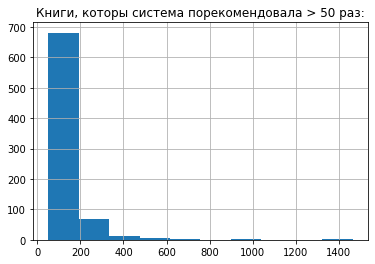

In [122]:
predicted_books.query('recs_pop > 50').recs_pop.hist();
plt.title("Книги, которы система порекомендовала > 50 раз:")
plt.show()

Возможно, именно здесь находятся рекомендации, которые попали в яблочко)

### (4.3) Общий Hit-Rate

- Напишем функцию для попарного сравнения `датафреймов с рекомендациями`

- Она пригодится нам для оценки качества предсказаний

In [123]:
def compare_two_df(df1, df2):
  """
  Объединяет два датафрейма по парам (читатель, книга)

  в результате остается только их пересечение(там, где пары совпали)
  """

  res = pd.merge(df1[['chb', 'sys_numb']],
                 df2[['chb', 'sys_numb']],
                 on=['chb', 'sys_numb'], how='inner')

  return res


# Сохраняем датасет с предсказаниями, которые попали в точку
compare_results = compare_two_df(all_users_predictions, test_data)

- Посмотрим, какое количество книг мы в среднем угадали для каждого пользователя.


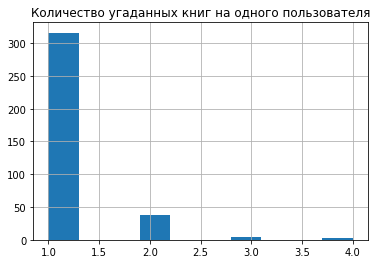

In [125]:
true_books = compare_two_df(all_users_predictions, test_data)
true_books.groupby('chb').count().hist()
plt.title("Количество угаданных книг на одного пользователя")
plt.show()

**Вывод**

Мы "захватили" ~500 читателей

  - Для  большинства угадали одну книгу

  - Есть и те, для которых у нас даже 3 и 4 попадания)

Возможно, это рекордсмены, которые заказывают больше 1000 книг? Проверим!

### (4.4) Какие книги мы угадываем?

С реальными читателями мы узнаем это только после запуска системы в продакшен.

Попробуем пока разгадать тайну тестовых данных (что работает, а что нет)

In [126]:
true_books = true_books.set_index('sys_numb').join(predicted_books)

In [127]:
true_books.sort_values(by='recs_pop', ascending=False).head(20)

,chb,recs_pop,users_count,author,title,bbk
sys_numb,,,,,,
RSL01009824143,200001024503,387,16,none,С Рождеством Христовым! Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009824143,300000729937,387,16,none,С Рождеством Христовым! Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009824143,200000944083,387,16,none,С Рождеством Христовым! Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009824143,200000839923,387,16,none,С Рождеством Христовым! Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009824143,200000794551,387,16,none,С Рождеством Христовым! Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01009824143,100000954431,387,16,none,С Рождеством Христовым! Изоматериал : Открытка,Щ158.9открытки3(2Р=Р)53-3
RSL01002890388,200000866607,357,15,none,"Архитектура Москвы, 1920-1960 = Moscow archite...",Н0(2Р=Р)92Москва07я23
RSL01002890388,300000860566,357,15,none,"Архитектура Москвы, 1920-1960 = Moscow archite...",Н0(2Р=Р)92Москва07я23
RSL01003015223,300000973621,339,9,"Панофский, Эрвин 1892-1968","Ренессанс и ""ренессансы"" в искусстве Запада","Щ103(0)43,0"


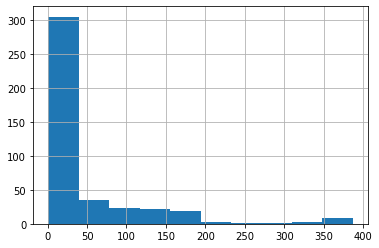

In [128]:
true_books.recs_pop.hist();

**Вывод 1**

- Лишь 4 книги, которыми мы распылялись тысячами, попали в яблочко

- В основном выйграли те, которых в рекомендательном датасете было < 200

In [129]:
(test_data.set_index('sys_numb')
.join(books_popularity)
.users_count.describe().to_frame('test')
.join(true_books.users_count.describe().to_frame('true_recs')))

,test,true_recs
count,45610.000000,419.000000
mean,1.459855,5.081146
std,1.128960,4.089677
min,1.000000,2.000000
25%,1.000000,2.000000
50%,1.000000,3.000000
75%,2.000000,6.000000
max,21.000000,21.000000


**Вывод 2**

- Из 75% книг, которые читали только один раз, мы не угадали ни одной

- Это логично, ведь идея Collaborative Filtering - использовать в рекомендациях данные о предпочтениях других читателях


###(4.5) Пользователи, которых мы угадываем



Попробуем выяснить, для каких читателей подходят наши рекомендации на базе Collaborative Filtering.

Возможно, мы угадываем книги лишь для того 1% читателей, кто уже прочитал по 100 и 200 книг?

In [135]:
print("Пользователи, для которых модель смогла предсказать книги:")
true_books.set_index('chb').join(user_books_count).sort_values(by='books_count')

Пользователи, для которых модель смогла предсказать книги:


,recs_pop,users_count,author,title,bbk,books_count
chb,,,,,,
200000935252,9,3,"Пономаренко, Сергей Владимирович",Основные этапы истории развития российской про...,none,2
300001093459,12,5,"По, Айрэн",Родовая Карма,"Э391.219,0",2
200001063517,15,3,none,Неорганическая химия. Химия элементов : учебни...,Г12я731-1,3
200000774458,55,5,"Медушевский, Андрей Николаевич 1960-",Демократия и авторитаризм: российский конститу...,none,3
200001117131,4,2,"Папазян, Георгий Самвелович",Социально-педагогические условия реализации во...,"Ч481,6(2)385.68,0",3
...,...,...,...,...,...,...
300000863416,4,5,отсутствует,отсутствует,отсутствует,747
300000863416,4,3,отсутствует,отсутствует,отсутствует,747
200001017435,1,2,отсутствует,отсутствует,отсутствует,805


In [139]:
print("Количество книг в истории пользователей\n",
      "для которых мы хорошо предсказываем:\n")

true_books.set_index('chb').join(user_books_count).books_count.describe()

Количество книг в истории пользователей
 для которых мы хорошо предсказываем:



count     419.000000
mean       53.558473
std       215.422847
min         2.000000
25%         9.000000
50%        18.000000
75%        36.500000
max      3914.000000
Name: books_count, dtype: float64

In [11]:
print("Количество книг в истории читателей\n",
      "в общем датасте:")
(transactions
 .drop_duplicates()
 .groupby('chb').sys_numb.count()
 .describe()
)

Количество книг в истории читателей
 в общем датасте:


count    16753.000000
mean        15.493703
std         75.221343
min          2.000000
25%          4.000000
50%          6.000000
75%         14.000000
max       6765.000000
Name: sys_numb, dtype: float64

**Вывод**

1. 50% пользователей, которым подошли наши рекомендации, прочитали больше 18 книг (вспомним, что по общему датасету этот показатель в 3 раза ниже)

1. При этом мы  попадали в яблочко и для пользователей, которые прочитали не больше 3-х книг

  - Возможно, они прочитали всего 3, но при этом популярные среди других читателей книги?

### (4.6) Неявные дубликаты книг 


Появилась идея, что кроме явных дубликатов (которые мы не используем в предсказаниях), в базе данных есть похожие книги с разными идентификаторами:

- Книги с разным годом издания

- Книги из одного сборника или серии

Получается, ALS-модель считает эти книги разными, и в каких-то случаях не может корректно объединить пользователей по интересам.

Посмотрим, много ли таких книг?

In [29]:
print("Книг в библиотеке с одинаковыми названиями:", items['title'].duplicated().sum())

Книг в библиотеке с одинаковыми названиями: 34534


- 34534!! А ведь это только сами копии, еще есть исходники

- Значит, минимум 50 000 одинаковых книг с разными изданиями



In [40]:
print("=>Примеры неявных дубликатов:<=\n")

(items
 .groupby(['title', 'author'])
 .year_izd.nunique().sort_values()).tail(15)

=>Примеры неявных дубликатов:<=



title                                                                                                                                                                                                                                   author                                 
Методические и информационные материалы по правовой пропаганде                                                                                                                                                                          none                                        5
Философия : учебник                                                                                                                                                                                                                     none                                        5
Веды о силе времени : практические рекомендации для процветания                                                                                                             

- Часть дубликатов мы еще не видим, т.к. названия могут немного отличаться (особенно, если это книги одной серии или сборника)

- Посмотрим пример с братьями Гримм




In [37]:
items[items.title.str.contains('Лучшие сказки братьев Гриммов')]

,sys_numb,title,author,izd,year_izd,bbk
353346,RSL01003628565,Лучшие сказки братьев Гриммов : Пособие для кл...,"Гримм, Якоб 1785-1863","кн. маг. В. Думнова, п/ф ""Насл. бр. Салаевых""",1910,none
353349,RSL01003628562,Лучшие сказки братьев Гриммов : Пособие для кл...,"Гримм, Якоб 1785-1863","кн. маг. В. Думнова, п/ф ""Насл. бр. Салаевых""",1905,none
353351,RSL01003628566,Лучшие сказки братьев Гриммов : Пособие для кл...,"Гримм, Якоб 1785-1863","кн. маг. В. Думнова, п/ф ""Насл. бр. Салаевых""",1911,none
353352,RSL01003628560,Лучшие сказки братьев Гриммов : Пособие для кл...,"Гримм, Якоб 1785-1863","кн. маг. В. Думнова, п/ф ""Насл. бр. Салаевых""",1899,none
353354,RSL01003628559,Лучшие сказки братьев Гриммов : Пособие для кл...,"Гримм, Якоб 1785-1863","кн. маг. В. Думнова, п/ф ""Насл. бр. Салаевых""",1893,none
353356,RSL01003628558,Лучшие сказки братьев Гриммов : Пособие для кл...,"Гримм, Якоб 1785-1863","кн. маг. В. Думнова, п/ф ""Насл. бр. Салаевых""",1891,none
353357,RSL01003628567,Лучшие сказки братьев Гриммов : Пособие для кл...,"Гримм, Якоб 1785-1863","кн. маг. В. Думнова, п/ф ""Насл. бр. Салаевых""",1914,none
353359,RSL01003628564,Лучшие сказки братьев Гриммов : Пособие для кл...,"Гримм, Якоб 1785-1863","кн. маг. В. Думнова, п/ф ""Насл. бр. Салаевых""",1909,none
353360,RSL01003628563,Лучшие сказки братьев Гриммов : Пособие для кл...,"Гримм, Якоб 1785-1863","кн. маг. В. Думнова, п/ф ""Насл. бр. Салаевых""",1908,none


**Вывод**

На неявных дубликатах модель ALS делает неправильные выводы

- Если объединить книги на этапе обучения, то это должно повысить качество предсказаний

- Останется вопрос какую из группы похожих книг порекомендовать пользователю) 